In [ ]:
# Text preprocessing of parallel data for baseline training corpus

In [4]:
import pandas as pd
import seaborn as sns
import glob
import re
import math
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
!pip install nltk
from nltk.tokenize import word_tokenize

# get all files based on language

de_files = glob.glob('bar-de/raw/*.de')
bar_files = glob.glob('bar-de/raw/*.bar')

print(bar_files)
print(de_files)

  Using cached nltk-3.7-py3-none-any.whl (1.5 MB)
  Using cached regex-2022.10.31-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (769 kB)
['bar-de/raw/2_tatoeba.train.bar', 'bar-de/raw/0_tatoeba.dev.bar', 'bar-de/raw/3_Tatoeba.bar-de.bar', 'bar-de/raw/5_wiki_woerterbuch.bar', 'bar-de/raw/4_wikimedia.bar-de.bar', 'bar-de/raw/6_XLEnt.bar-de.bar', 'bar-de/raw/1_tatoeba.test.bar']
['bar-de/raw/4_wikimedia.bar-de.de', 'bar-de/raw/1_tatoeba.test.de', 'bar-de/raw/0_tatoeba.dev.de', 'bar-de/raw/3_Tatoeba.bar-de.de', 'bar-de/raw/5_wiki_woerterbuch.de', 'bar-de/raw/2_tatoeba.train.de', 'bar-de/raw/6_XLEnt.bar-de.de']


In [5]:
# reorder parallel files

bar_files_reordered = sorted(bar_files)
de_files_reordered = sorted(de_files)

print(bar_files_reordered)
print(de_files_reordered)

['bar-de/raw/0_tatoeba.dev.bar', 'bar-de/raw/1_tatoeba.test.bar', 'bar-de/raw/2_tatoeba.train.bar', 'bar-de/raw/3_Tatoeba.bar-de.bar', 'bar-de/raw/4_wikimedia.bar-de.bar', 'bar-de/raw/5_wiki_woerterbuch.bar', 'bar-de/raw/6_XLEnt.bar-de.bar']
['bar-de/raw/0_tatoeba.dev.de', 'bar-de/raw/1_tatoeba.test.de', 'bar-de/raw/2_tatoeba.train.de', 'bar-de/raw/3_Tatoeba.bar-de.de', 'bar-de/raw/4_wikimedia.bar-de.de', 'bar-de/raw/5_wiki_woerterbuch.de', 'bar-de/raw/6_XLEnt.bar-de.de']


In [6]:
# read files into list as lines

bar_lines = []

for file in bar_files_reordered:
    with open(file) as f:
        for line in f.readlines():
            bar_lines.append(line.rstrip(" \n"))
            
de_lines = []

for file in de_files_reordered:
    with open(file) as f:
        for line in f.readlines():
            de_lines.append(line.rstrip(" \n"))           

In [7]:
# check no. of lines

print("Bavarian Parallel Lines", len(bar_lines))
print("German Parallel Lines: ", len(de_lines))

Bavarian Parallel Lines 57944
German Parallel Lines:  57944


In [8]:
print(bar_lines[100:105])
print(de_lines[100:105])

['Artikel im Tages - Anzeiger', 'englisch', 'Owa des lossat se nua mid an bessan Vaständniss vo da Quantenphysik eaklean.', 'Nach Beendigung der Förderung schenkte Mobil Oil den hier aufgestellten Pumpenbock der Gemeinde.', 'Da Ort is 822 easchtmois urkundlich ois perge cum basilica (Althochdeutsch/Vulgärlatein „Berg mit Kiach“) erwähnt wordn.']
['Tages - Anzeiger', 'Portugiesisch', 'Awiz eχwamiz kwaþe: «Χertôn gaángwjedai mez seχwandi eχwanz gumanun akandun.»', 'Nach Beendigung der Förderung schenkte Mobil Oil den hier aufgestellten Pumpenbock der Gemeinde.', 'Der Ort wurde 822 erstmals urkundlich als perge cum basilica (Althochdeutsch/Vulgärlatein Berg mit Kirche) erwähnt.']


In [9]:
# transform lists of lines into dataframe

df = pd.DataFrame(bar_lines, columns = ["bar"])
df["de"] = de_lines
df.head()

,bar,de
0,Da Thomas und seine Freind spün Fangerl.,Thomas und seine Freunde spielen fangen.
1,Fuffzig oda fuffzehn?,Hast du fünfzig oder fünfzehn gesagt?
2,Heit hob i goa ned gnapfitzt.,Heute habe ich kein Nickerchen gemacht.
3,Red do net so an Stüfi daher!,Red doch nicht so einen Stiefel daher!
4,Red do net so an Stuss zsamm!,Rede doch nicht so ’n Blech!


In [10]:
# text preprocessing

def preprocess(text):
    
    text = str(text).lower()
    
    # remove parenthesized texts
    text = re.sub(r"\(.*?\)", "", text)
    
    # remove brackets
    text = re.sub(r"\[.*?\]", "", text)

    # remove quotation marks
    text = re.sub(r'(\<|\>|"|“|”|„|»|«)*', "", text)

    # remove http websites
    text = re.sub(r"(https?:\/\/)[a-zA-Z1-9_.@?=#\/*]*", "", text)

    # remove other symbols
    text = re.sub(r"(\*|\+|@|#|:|;)*", "", text)
    
    # remove parenthesis again
    text = text.replace("(", "").replace(")", "")

    # trim extra whitespace
    text = re.sub(r' {2,100}', "", text)

    return text

In [11]:
df["bar"] = df["bar"].apply(preprocess)
df["de"] = df["de"].apply(preprocess)

In [12]:
# determine average length of lines
def count_letters(text):
    return len(text)

df["letters"] = df["bar"].apply(count_letters)

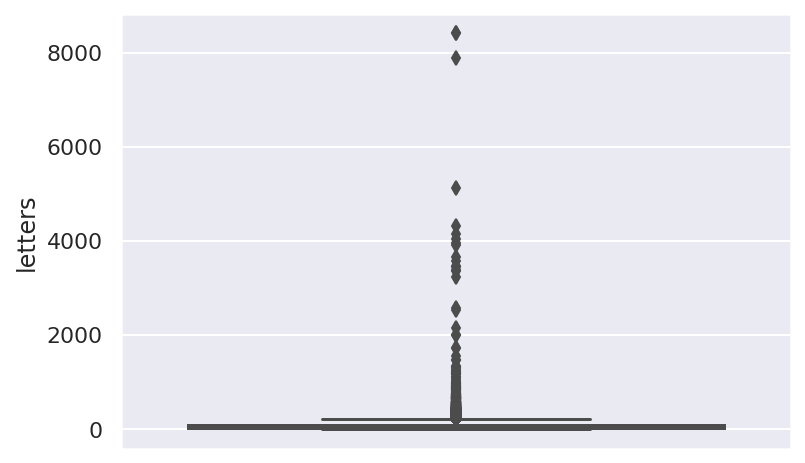

In [13]:
# plot length of lines
sns.set_theme(style = "whitegrid")
sns.set(rc = {'figure.figsize':(7, 11)})
%config InlineBackend.figure_format = 'retina'

ax = sns.boxplot(y = "letters", data = df)

In [14]:
# smart truncate sentences so that sentences are not too long
# https://stackoverflow.com/questions/250357/truncate-a-string-without-ending-in-the-middle-of-a-word

def smart_truncate(content, length = 90, suffix = '.'):
    if len(content) <= length:
        return content
    else:
        return ' '.join(content[:length + 1].split(' ')[0:-1]) + suffix
    
df["bar"] = df["bar"].apply(smart_truncate)
df["de"] = df["de"].apply(smart_truncate)

In [15]:
# remove duplicates and empty lines
df = df.dropna()
df = df.drop_duplicates(subset = ['bar', "de"])

In [16]:
# calculate cosine similarity
# https://stackoverflow.com/questions/15173225/calculate-cosine-similarity-given-2-sentence-strings

WORD = re.compile(r"[^ ]")

def get_cosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
    sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator

def text_to_vector(text):
    words = WORD.findall(text)
    return Counter(words)

In [17]:
cosine_values = []

for i in range(len(df)):
    text1 = df.iloc[i, 0] # bar
    text2 = df.iloc[i, 1] # de
    
    vector1 = text_to_vector(text1)
    vector2 = text_to_vector(text2)
    cosine = get_cosine(vector1, vector2)
    
#     print(cosine)
    cosine_values.append(cosine)

In [18]:
df["cosine"] = cosine_values
df.head()

,bar,de,letters,cosine
0,da thomas und seine freind spün fangerl.,thomas und seine freunde spielen fangen.,40,0.940939
1,fuffzig oda fuffzehn?,hast du fünfzig oder fünfzehn gesagt?,21,0.756304
2,heit hob i goa ned gnapfitzt.,heute habe ich kein nickerchen gemacht.,29,0.681506
3,red do net so an stüfi daher!,red doch nicht so einen stiefel daher!,29,0.878350
4,red do net so an stuss zsamm!,rede doch nicht so ’n blech!,29,0.521648


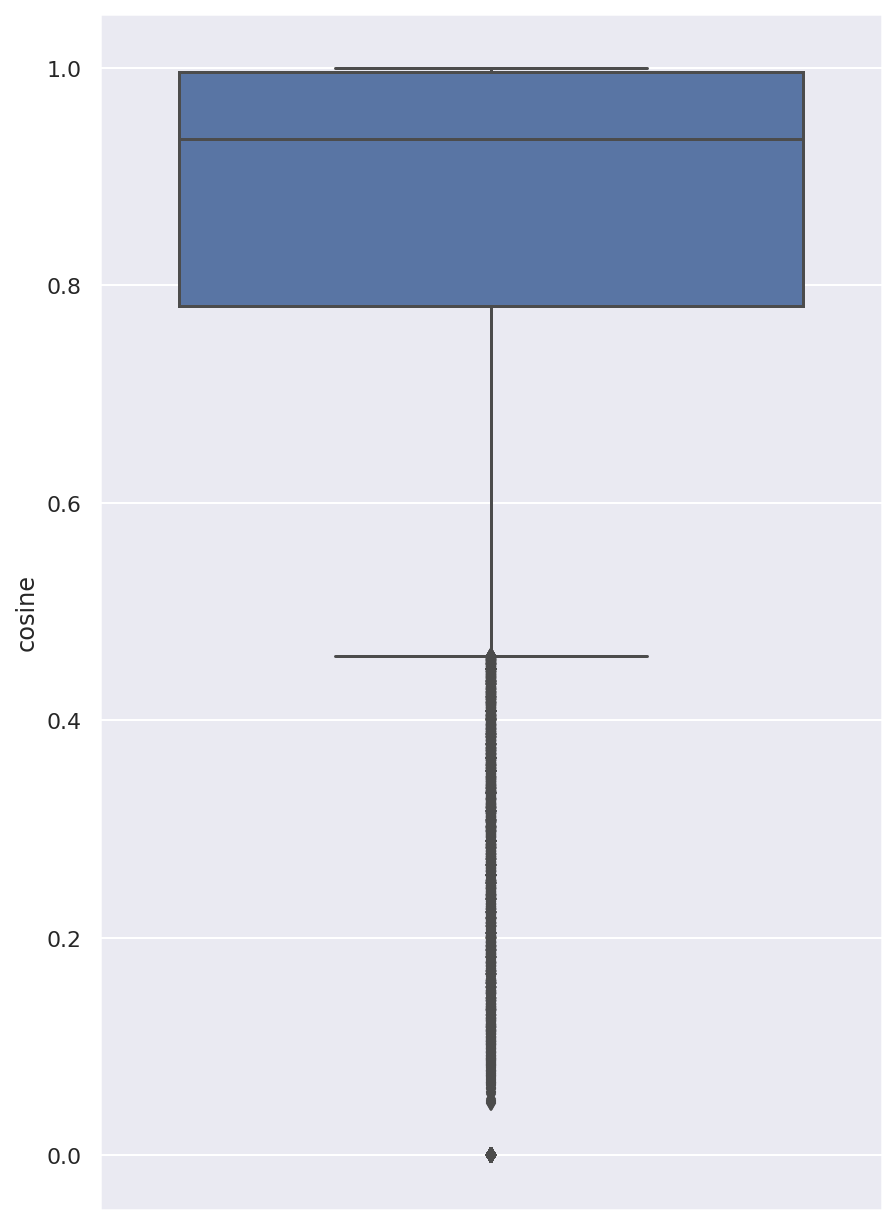

In [19]:
sns.set_theme(style = "whitegrid")
sns.set(rc = {'figure.figsize':(7, 11)})
ax = sns.boxplot(y = "cosine", data = df)

In [20]:
# remove rows with less probability of parallelity
# which is the long tail of the whisker plot
df = df[df["cosine"] > 0.48]
print("Length Dataframe (cosine similarity):", len(df))

Length Dataframe (cosine similarity): 42266


In [21]:
# tokenize texts
def nltk_tokenize(text):
    tokenized = word_tokenize(text)
    if len(tokenized[-1]) != 1:
        tokenized.append(".")
    return " ".join(tokenized)

df["bar"] = df["bar"].apply(nltk_tokenize)
df["de"] = df["de"].apply(nltk_tokenize)

In [22]:
df = df.sample(frac = 1).reset_index(drop = True)
df.head()

,bar,de,letters,cosine
0,da espace middllandis a grossregion in da schw...,der espace mittelland ist eine grossregion in ...,50,0.870844
1,juli 2009 bis zum 10 .,2009 bis dez .,21,0.747265
2,"band 50 , iberoamericana/vervuert , frankfurt ...","band 50. iberoamericana/vervuert , frankfurt a...",124,0.996198
3,johann jakob wicks nachrichtensammlung .,johann jakob wicks nachrichtensammlung .,38,1.000000
4,"wagenbach , berlin 2001 .","wagenbach , berlin 2001 .",23,1.000000


In [23]:
df1, df2, df3, df4, df5 = np.array_split(df, 5)

In [26]:
print("df1 length: ", len(df1))
print("df2 length: ", len(df2))
print("df3 length: ", len(df3))
print("df4 length: ", len(df4))
print("df5 length: ", len(df5))

df1 length:  8454
df2 length:  8453
df3 length:  8453
df4 length:  8453
df5 length:  8453


In [27]:
with open("bar-de/cv/bar-1", "w") as file:
    for line in df1["bar"]:
        file.write(line + "\n")
        
with open("bar-de/cv/bar-2", "w") as file:
    for line in df2["bar"]:
        file.write(line + "\n")

with open("bar-de/cv/bar-3", "w") as file:
    for line in df3["bar"]:
        file.write(line + "\n")
        
with open("bar-de/cv/bar-4", "w") as file:
    for line in df4["bar"]:
        file.write(line + "\n")
        
with open("bar-de/cv/bar-5", "w") as file:
    for line in df5["bar"]:
        file.write(line + "\n")

# for de
        
with open("bar-de/cv/de-1", "w") as file:
    for line in df1["de"]:
        file.write(line + "\n")
        
with open("bar-de/cv/de-2", "w") as file:
    for line in df2["de"]:
        file.write(line + "\n")

with open("bar-de/cv/de-3", "w") as file:
    for line in df3["de"]:
        file.write(line + "\n")
        
with open("bar-de/cv/de-4", "w") as file:
    for line in df4["de"]:
        file.write(line + "\n")
        
with open("bar-de/cv/de-5", "w") as file:
    for line in df5["de"]:
        file.write(line + "\n")